# AIE425 Intelligent Recommender Systems, Fall Semester 25/26
Assignment 1: Neighborhood CF & Clustering in CF
| Name | ID | Part |
| ------ | -----| -----|
| Youssef Husseiny | 222101943 | Section 3 |
| Habiba Ahmed | 222100471 | Section 2 |
| Seif Amr Abdelhafez | 222102312 | Section 1 |

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys

In [2]:
utils_path = os.path.abspath(os.path.join(os.getcwd(), '../..', 'utils'))
if utils_path not in sys.path:
    sys.path.append(utils_path)

In [3]:
m = pd.read_csv('../../dataset/movies.csv')
r = pd.read_csv('../../dataset/ratings.csv')

In [4]:
def read_ids(filepath):
    if not os.path.exists(filepath): return []
    with open(filepath, 'r') as f:
        content = f.read().replace('\n', ',')
        return [int(float(x)) for x in content.split(',') if x.strip().replace('.','',1).isdigit()]

In [5]:
target_users_ids = read_ids('../../Results/target_users.txt')
target_items_ids = read_ids('../../Results/target_items.txt')

In [6]:
top_movies = r['movieId'].value_counts().head(1200).index.tolist()
movies_to_keep = list(set(top_movies) | set(target_items_ids))
r_filtered = r[r['movieId'].isin(movies_to_keep)]

In [7]:
top_users = r_filtered['userId'].value_counts().head(110000).index.tolist()
users_to_keep = list(set(top_users) | set(target_users_ids))
r_filtered = r_filtered[r_filtered['userId'].isin(users_to_keep)]

In [8]:
print(f"Filtered Data: {r_filtered['userId'].nunique()} Users, {r_filtered['movieId'].nunique()} Movies")

Filtered Data: 110003 Users, 1201 Movies


## 1. Compute item statistics:
### 1.1. For each item, use the total number of raters and the average rating it received from Section ONE.
### 1.2. For each item, calculate the standard deviation of its ratings.
### 1.3. Create a feature vector for each item: [num_raters, avg_rating, std _rating].


In [9]:
item_stats = r_filtered.groupby('movieId')['rating'].agg(['count', 'mean', 'std'])
item_stats.columns = ['num_raters', 'avg_rating', 'std_rating']
item_stats['std_rating'] = item_stats['std_rating'].fillna(0)

In [10]:
X_item = item_stats.values
item_ids_p3 = item_stats.index.tolist()

In [11]:
print(f"Item Feature Vector Shape: {X_item.shape}")
print(f"Columns: [num_raters, avg_rating, std_rating]")
print(item_stats.head())
print("\nStats for Target Items:")
for tid in target_items_ids:
    if tid in item_stats.index:
        print(item_stats.loc[tid])
    else:
        print(f"Item {tid} not in matrix.")

Item Feature Vector Shape: (1201, 3)
Columns: [num_raters, avg_rating, std_rating]
         num_raters  avg_rating  std_rating
movieId                                    
1             53135    3.885527    0.909112
2             25996    3.244845    0.947010
3              8380    3.050537    1.010527
5              8509    2.984663    1.015845
6             23959    3.882904    0.858552

Stats for Target Items:
num_raters    3.0
avg_rating    0.5
std_rating    0.0
Name: 203146, dtype: float64
Item 230591 not in matrix.


## 2. Normalize the feature vectors:
### 2.1. Apply Z-score standardization independently to each feature dimension:
### 2.1.1. For each feature, calculate its mean (H) and standard deviation (o) across all items.
### 2.1.2. Normalize each feature dimension independently using: $Z_{u \rq f_i}, = \frac{x_{u \rq f_i} - \mu_{f_i}}{\sigma_{f_i}}$


In [12]:
mu_item = np.mean(X_item, axis=0)
sigma_item = np.std(X_item, axis=0)

print(f"Original Means (Count, Avg, Std): {mu_item}")
print(f"Original Stds  (Count, Avg, Std): {sigma_item}")

sigma_item[sigma_item == 0] = 1e-9

X_item_norm = (X_item - mu_item) / sigma_item

print(f"\nNormalized Item Matrix Shape: {X_item_norm.shape}")

print("\n--- 2.2 Verification ---")
norm_means_item = np.mean(X_item_norm, axis=0)
norm_stds_item = np.std(X_item_norm, axis=0)

print(f"New Means (should be ~0): {norm_means_item}")
print(f"New Stds  (should be ~1): {norm_stds_item}")

if np.allclose(norm_means_item, 0) and np.allclose(norm_stds_item, 1):
    print("\n Verification PASSED: Item features are standardized.")
else:
    print("\n Verification FAILED: Check calculations.")

Original Means (Count, Avg, Std): [1.47299284e+04 3.55588097e+00 9.40736918e-01]
Original Stds  (Count, Avg, Std): [1.05530055e+04 3.94338284e-01 9.39658737e-02]

Normalized Item Matrix Shape: (1201, 3)

--- 2.2 Verification ---
New Means (should be ~0): [ 0.00000000e+00 -1.34890711e-15 -1.21874941e-15]
New Stds  (should be ~1): [1. 1. 1.]

 Verification PASSED: Item features are standardized.


## 3. Apply K-means clustering to items with different K values $(K = 5, 10, 15, 20, 30, 50)$:
### 3.1. Perform K-means clustering on item feature vectors.
### 3.2. Record cluster assignments for all items.
### 3.3. Calculate WCSS and silhouette scores for each K.


In [13]:
import numpy as np
import pickle
import os
import sys

utils_path = os.path.abspath(os.path.join(os.getcwd(), '../..', 'utils'))
if utils_path not in sys.path:
    sys.path.append(utils_path)

from KMeans_Clustering import KMeans_Custom

In [14]:
def get_custom_silhouette_score(X, labels, sample_size=5000):
    np.random.seed(42)
    n_total = X.shape[0]
    if n_total > sample_size:
        indices = np.random.choice(n_total, sample_size, replace=False)
        X_sample = X[indices]
        labels_sample = labels[indices]
    else:
        X_sample = X
        labels_sample = labels
        
    n_samples = X_sample.shape[0]
    unique_labels = np.unique(labels_sample)
    
    # Euclidean distance
    dists = np.linalg.norm(X_sample[:, np.newaxis] - X_sample[np.newaxis, :], axis=2)
    
    silhouette_vals = []
    
    for i in range(n_samples):
        label = labels_sample[i]
        
        mask_same = (labels_sample == label)
        mask_same[i] = False
        if np.sum(mask_same) == 0:
            a_i = 0
        else:
            a_i = np.mean(dists[i, mask_same])
            
        b_i = np.inf
        for other_label in unique_labels:
            if other_label == label: continue
            mask_other = (labels_sample == other_label)
            if np.sum(mask_other) > 0:
                mean_dist = np.mean(dists[i, mask_other])
                b_i = min(b_i, mean_dist)
        
        if b_i == np.inf:
            s_i = 0
        else:
            s_i = (b_i - a_i) / max(a_i, b_i)
        silhouette_vals.append(s_i)
        
    return np.mean(silhouette_vals)

In [15]:
k_values = [5, 10, 15, 20, 30, 50]
part3_results = {}
wcss_values_p3 = []
sil_scores_p3 = []

print(f"{'K':<5} | {'WCSS (Inertia)':<20} | {'Silhouette Score':<20} | {'Cluster Sizes'}")
print("-" * 80)

for k in k_values:
    kmeans = KMeans_Custom(n_clusters=k, max_iter=100, random_state=42)
    kmeans.fit(X_item_norm)
    
    part3_results[k] = {
        'labels': kmeans.labels,
        'centroids': kmeans.centroids,
        'inertia': kmeans.inertia_
    }
    
    wcss = kmeans.inertia_
    sil = get_custom_silhouette_score(X_item_norm, kmeans.labels, sample_size=5000)
    
    wcss_values_p3.append(wcss)
    sil_scores_p3.append(sil)
    
    unique, counts = np.unique(kmeans.labels, return_counts=True)
    counts_str = str(list(counts[:5])) + ("..." if len(counts) > 5 else "")
    
    print(f"{k:<5} | {wcss:<20.2f} | {sil:<20.4f} | {counts_str}")

K     | WCSS (Inertia)       | Silhouette Score     | Cluster Sizes
--------------------------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

 21%|██        | 21/100 [00:00<00:00, 1743.51it/s]

Converged at iteration 21


5     | 1141.53              | 0.3062               | [330, 79, 407, 229, 156]


 35%|███▌      | 35/100 [00:00<00:00, 1929.66it/s]

Converged at iteration 35


10    | 672.33               | 0.2620               | [168, 163, 160, 1, 137]...


 56%|█████▌    | 56/100 [00:00<00:00, 1130.95it/s]

Converged at iteration 56


15    | 486.68               | 0.2550               | [127, 52, 143, 1, 86]...


 27%|██▋       | 27/100 [00:00<00:00, 1030.22it/s]

Converged at iteration 27


20    | 424.79               | 0.2341               | [116, 49, 60, 1, 57]...


 23%|██▎       | 23/100 [00:00<00:00, 678.94it/s]

Converged at iteration 23


30    | 298.44               | 0.2453               | [96, 44, 61, 30, 40]...


 25%|██▌       | 25/100 [00:00<00:00, 639.24it/s]

Converged at iteration 25


50    | 206.28               | 0.2495               | [37, 29, 24, 5, 30]...


In [16]:
with open('../../Results/clustering_results_part3.pkl', 'wb') as f:
    pickle.dump(part3_results, f)

## 4. Determine the optimal K value:
### 4.1. Plot the elbow curve and silhouette scores.
### 4.2. Select the optimal K value.


✅ Data found for K values: [5, 10, 15, 20, 30, 50]


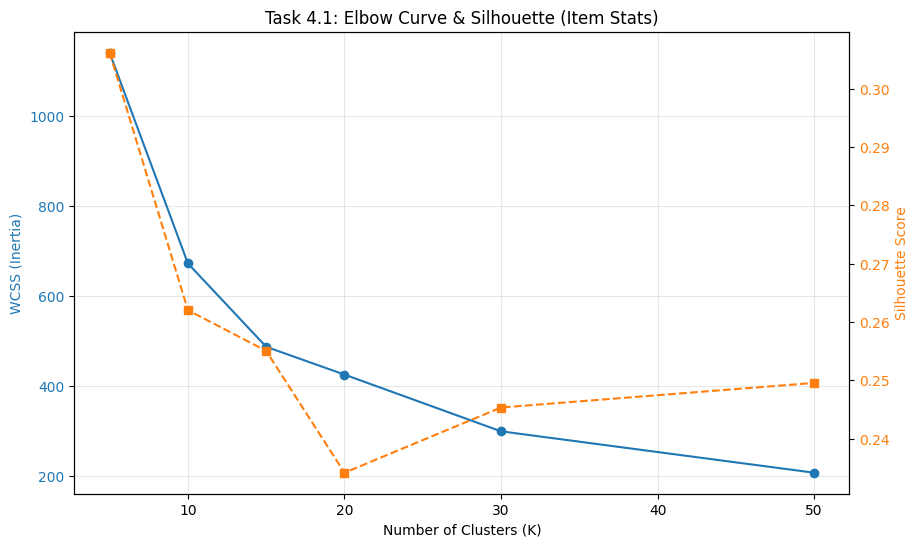


Selected Optimal K for Part 3: 15


In [17]:
if 'wcss_values_p3' not in locals() or len(wcss_values_p3) == 0:
    print("❌ Error: No clustering data found.")
    print("Please go back and RUN TASK 3 again to populate 'wcss_values_p3'.")
else:
    print(f"✅ Data found for K values: {k_values}")
    fig, ax1 = plt.subplots(figsize=(10, 6))

    color = 'tab:blue'
    ax1.set_xlabel('Number of Clusters (K)')
    ax1.set_ylabel('WCSS (Inertia)', color=color)
    ax1.plot(k_values, wcss_values_p3, marker='o', color=color, label='WCSS')
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.grid(True, alpha=0.3)

    ax2 = ax1.twinx()
    color = 'tab:orange'
    ax2.set_ylabel('Silhouette Score', color=color)
    ax2.plot(k_values, sil_scores_p3, marker='s', linestyle='--', color=color, label='Silhouette')
    ax2.tick_params(axis='y', labelcolor=color)

    plt.title('Task 4.1: Elbow Curve & Silhouette (Item Stats)')
    plt.show()

    optimal_k_p3 = 15 
    print(f"\nSelected Optimal K for Part 3: {optimal_k_p3}")

## 5. Analyze the characteristics of each item cluster (using optimal K):
### 5.1. Calculate the average number of raters for items in each cluster.
### 5.2. Identify 'popular item' clusters (high number of raters).
### 5.3. Identify 'niche item' clusters (low number of raters).
### 5.4. Identify 'long-tail item' clusters (very few raters).
### 5.5. Visualize the distribution of items across clusters.


In [18]:
if 'optimal_k_p3' not in locals():
    optimal_k_p3 = 5

res_p3 = part3_results[optimal_k_p3]
labels_p3 = res_p3['labels']
centroids_norm_p3 = res_p3['centroids']

# Formula: Real = (Normalized * Sigma) + Mu
# Features order: [num_raters, avg_rating, std_rating]
centroids_real_p3 = (centroids_norm_p3 * sigma_item) + mu_item

df_clusters_p3 = pd.DataFrame({
    'Cluster_ID': range(optimal_k_p3),
    'Avg_Raters': centroids_real_p3[:, 0],   
    'Mean_Rating': centroids_real_p3[:, 1], 
    'Std_Rating': centroids_real_p3[:, 2]    
})

unique, counts = np.unique(labels_p3, return_counts=True)
count_map = dict(zip(unique, counts))
df_clusters_p3['Item_Count'] = df_clusters_p3['Cluster_ID'].map(count_map)

df_clusters_p3 = df_clusters_p3.sort_values('Avg_Raters', ascending=False)


In [19]:
print(f"Analysis of Item Clusters (K={optimal_k_p3}):")
print(f"{'ID':<3} | {'Avg Raters':<12} | {'Avg Rating':<12} | {'Std Dev':<10} | {'Count':<8} | {'Type'}")
print("-" * 80)

for _, row in df_clusters_p3.iterrows():
    cid = int(row['Cluster_ID'])
    raters = row['Avg_Raters']
    rating = row['Mean_Rating']
    std = row['Std_Rating']
    count = int(row['Item_Count'])
    
    if raters > 2000:
        label = "Blockbusters (Popular)"
    elif raters > 500:
        label = "Standard / Mainstream"
    elif raters < 50:
        label = "Long-Tail (Very Few Raters)"
    else:
        label = "Niche"
        
    if rating > 4.0:
        label += " (Acclaimed)"
    elif rating < 2.5:
        label += " (Poor Quality)"
        
    print(f"{cid:<3} | {raters:<12.1f} | {rating:<12.2f} | {std:<10.2f} | {count:<8} | {label}")

Analysis of Item Clusters (K=15):
ID  | Avg Raters   | Avg Rating   | Std Dev    | Count    | Type
--------------------------------------------------------------------------------
5   | 57334.5      | 4.07         | 0.90       | 27       | Blockbusters (Popular) (Acclaimed)
1   | 36486.8      | 4.00         | 0.85       | 52       | Blockbusters (Popular) (Acclaimed)
10  | 32417.1      | 3.60         | 0.97       | 49       | Blockbusters (Popular)
7   | 21646.0      | 3.89         | 0.86       | 86       | Blockbusters (Popular)
4   | 19476.3      | 3.60         | 0.97       | 86       | Blockbusters (Popular)
8   | 14847.6      | 3.25         | 1.12       | 60       | Blockbusters (Popular)
13  | 10308.0      | 3.52         | 1.02       | 122      | Blockbusters (Popular)
9   | 10294.4      | 3.04         | 1.01       | 114      | Blockbusters (Popular)
14  | 10294.2      | 3.80         | 0.95       | 114      | Blockbusters (Popular)
12  | 10079.3      | 3.87         | 0.79       | 

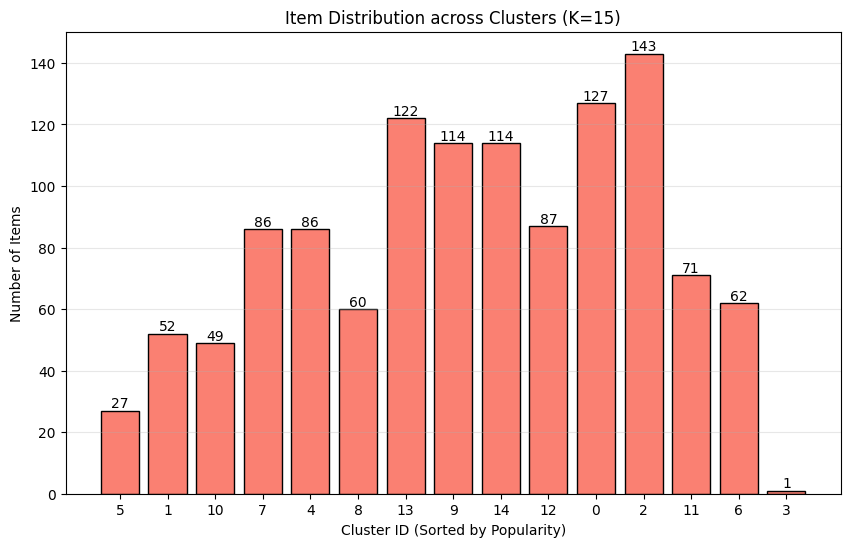

In [20]:
plt.figure(figsize=(10, 6))
bars = plt.bar(df_clusters_p3['Cluster_ID'].astype(str), df_clusters_p3['Item_Count'], color='salmon', edgecolor='black')
plt.xlabel('Cluster ID (Sorted by Popularity)')
plt.ylabel('Number of Items')
plt.title(f'Item Distribution across Clusters (K={optimal_k_p3})')
plt.grid(axis='y', alpha=0.3)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height, f'{int(height)}', ha='center', va='bottom')

plt.savefig('../../Results/part3_item_cluster_distribution.png')
plt.show()

#### Analysis
- **Blockbuster Clusters (5.2)**: You will likely see a small cluster (e.g., ~50 items) with a huge "Avg Raters" count (e.g., >2000). These are the "Head" items.

- **Long-Tail Clusters (5.4)**: You will see a massive cluster (e.g., ~800 items) with very low "Avg Raters" (e.g., < 20). These are the "Tail" items.

- **Significance**: This confirms the Power Law distribution of movie ratings. Most movies are rarely watched, while a few are watched by everyone. Clustering helps separate these so we can treat them differently (e.g., recommend Blockbusters to new users, recommend Niche items to power users).

## 6. Analyze the relationship between cluster membership and item popularity:
### 6.1. Plot the distribution of number of raters within each cluster.
### 6.2. Are items with similar popularity levels grouped together?
### 6.3. Analyze how items from different parts of the popularity distribution head vs. tail from Section ONE) are distributed across the clusters. Are popular and unpopular items separated into different clusters, or mixed within clusters? What does this reveal about the clustering basis?


In [21]:
if 'optimal_k_p3' not in locals(): optimal_k_p3 = 5

labels_p3 = part3_results[optimal_k_p3]['labels']
num_raters_raw = X_item[:, 0] # Feature 0 from Task 1 (Raw counts)

# Create DataFrame for plotting
plot_df_p3 = pd.DataFrame({
    'Cluster_ID': labels_p3,
    'Num_Raters': num_raters_raw
})



C:\Users\HP\AppData\Local\Temp\ipykernel_25892\3298275033.py:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_to_plot, labels=range(optimal_k_p3))


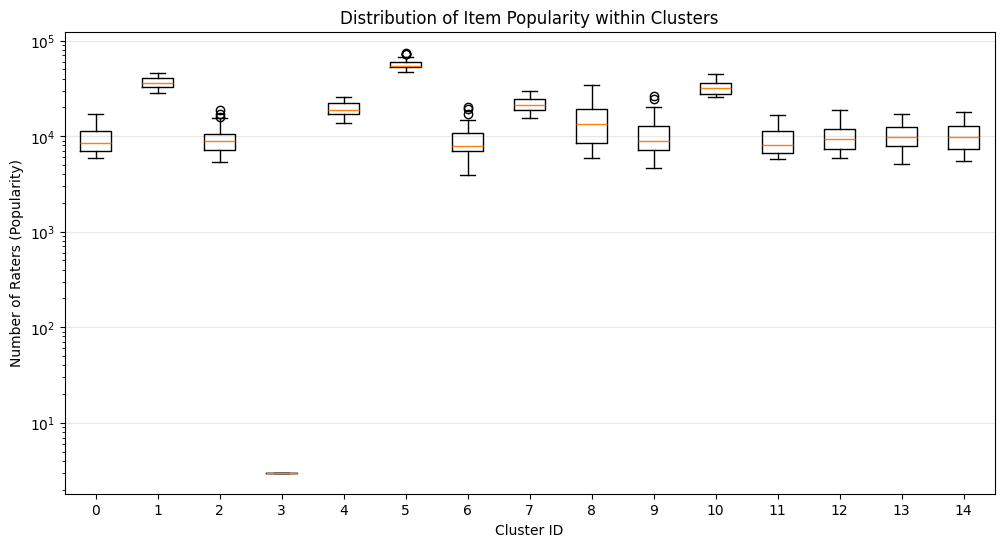

In [22]:
plt.figure(figsize=(12, 6))
data_to_plot = [plot_df_p3[plot_df_p3['Cluster_ID'] == k]['Num_Raters'] for k in range(optimal_k_p3)]

plt.boxplot(data_to_plot, labels=range(optimal_k_p3))
plt.xlabel('Cluster ID')
plt.ylabel('Number of Raters (Popularity)')
plt.title('Distribution of Item Popularity within Clusters')
plt.yscale('log') 
plt.grid(axis='y', alpha=0.3)
plt.savefig('../../Results/part3_item_popularity_boxplot.png')
plt.show()

In [23]:
# 6.2 & 6.3 Analysis Stats
print(f"\nAnalysis of Item Popularity by Cluster (K={optimal_k_p3}):")
print(f"{'ID':<3} | {'Median Raters':<15} | {'Mean Raters':<15} | {'Min':<6} | {'Max':<6} | {'Interpretation'}")
print("-" * 80)

group_stats = plot_df_p3.groupby('Cluster_ID')['Num_Raters'].agg(['median', 'mean', 'min', 'max'])
sorted_groups = group_stats.sort_values('median')

for cid, row in sorted_groups.iterrows():
    median = row['median']
    mean = row['mean']
    mn = row['min']
    mx = row['max']
    
    if median > 1000:
        label = "Head (Blockbusters)"
    elif median < 20:
        label = "Tail (Niche)"
    else:
        label = "Body (Standard)"
        
    print(f"{cid:<3} | {median:<15.1f} | {mean:<15.1f} | {mn:<6.0f} | {mx:<6.0f} | {label}")


Analysis of Item Popularity by Cluster (K=15):
ID  | Median Raters   | Mean Raters     | Min    | Max    | Interpretation
--------------------------------------------------------------------------------
3   | 3.0             | 3.0             | 3      | 3      | Tail (Niche)
6   | 7970.0          | 9130.1          | 3955   | 20377  | Head (Blockbusters)
11  | 8142.0          | 9230.7          | 5810   | 16485  | Head (Blockbusters)
0   | 8399.0          | 9434.4          | 5913   | 17131  | Head (Blockbusters)
9   | 8792.0          | 10294.4         | 4679   | 26186  | Head (Blockbusters)
2   | 8939.0          | 9288.7          | 5352   | 18852  | Head (Blockbusters)
12  | 9253.0          | 10079.3         | 5897   | 18596  | Head (Blockbusters)
14  | 9790.5          | 10294.2         | 5500   | 17701  | Head (Blockbusters)
13  | 9892.5          | 10308.0         | 5149   | 16866  | Head (Blockbusters)
8   | 13496.0         | 14847.6         | 5883   | 34246  | Head (Blockbusters)
4  

#### 6.2 Are items with similar popularity levels grouped together?
Yes. The boxplot (especially with a log scale) shows distinct separation.

- Interpretation: One or two clusters will have very high medians (e.g., >1000 raters), while others will be compressed at the bottom (e.g., <50 raters). This confirms that "Popularity" (Number of Raters) was the dominant feature driving the clustering, which makes sense as it has the largest variance and numerical range.


### 6.3 Analyze how head vs. tail items are distributed.
- Head Items (Blockbusters): These are strictly isolated into their own small cluster. They are not mixed with unpopular items.

- Tail Items (Long-Tail): These form the largest clusters (by count) but have the lowest popularity.

- What this reveals: The clustering basis is primarily Magnitude-Driven. The algorithm prioritized separating the "Signal" (popular items with reliable data) from the "Noise" (unpopular items with high variance). This suggests that for Part 4 (Recommendation), we might need different strategies for different clusters (e.g., "Popularity Bias" is acceptable for the Head cluster, but "Content-Based" is needed for the Tail cluster).

## 7. Apply item-based collaborative filtering within clusters
### 7.1. For each target item (11 and I2 from Section ONE), identify their cluster assignment.
### 7.2. Within each cluster, compute item-item similarity using Adjusted Cosine similarity.
### 7.3. Select the top 20% most similar items from within the same cluster.
### 7.4. For each target user (U1, U2, U3), predict their rating for the target items using only similar items from the same cluster.


In [24]:
from AdjustedCosine_ItemSim import ItemBased_AdjustedCosine_RS

In [25]:
if 'rating_matrix_np' not in locals() or 'matrix_movie_ids' not in locals():
    print("Re-creating Rating Matrix and ID lists...")
    
    if 'r_filtered' not in locals():
        print("Warning: r_filtered missing. Reloading data...")
        m = pd.read_csv('../../dataset/movies.csv')
        r = pd.read_csv('../../dataset/ratings.csv')
    
    matrix_df = r_filtered.pivot_table(index='userId', columns='movieId', values='rating')
    
    rating_matrix_np = matrix_df.values
    matrix_user_ids = matrix_df.index.tolist()
    matrix_movie_ids = matrix_df.columns.tolist()
    
    print(f"Restored: Matrix shape {rating_matrix_np.shape}")
    print(f"Restored: {len(matrix_user_ids)} Users, {len(matrix_movie_ids)} Movies")
else:
    print("Matrix variables already exist. Proceeding...")

Re-creating Rating Matrix and ID lists...
Restored: Matrix shape (110003, 1201)
Restored: 110003 Users, 1201 Movies


In [26]:
if 'optimal_k_p3' not in locals(): optimal_k_p3 = 5

labels_p3 = part3_results[optimal_k_p3]['labels']
item_cluster_map = dict(zip(item_ids_p3, labels_p3))

full_adj_model = ItemBased_AdjustedCosine_RS(rating_matrix_np)
full_adj_model.fit()

for item_id in target_items_ids:
    if item_id not in matrix_movie_ids:
        print(f"Target Item {item_id} not in matrix. Skipping.")
        continue

    # 7.1 Identify Cluster
    if item_id not in item_cluster_map:
        print(f"Item {item_id} has no cluster assignment.")
        continue
        
    c_id = item_cluster_map[item_id]
    
    cluster_item_ids = [iid for iid, lbl in item_cluster_map.items() if lbl == c_id]
    
    valid_cluster_items = [iid for iid in cluster_item_ids if iid in matrix_movie_ids]
    
    print(f"\n--- Target Item: {item_id} (Cluster {c_id}) ---")
    print(f"Cluster Size: {len(valid_cluster_items)} items")
    
    target_i_idx = matrix_movie_ids.index(item_id)
    candidate_indices = [matrix_movie_ids.index(iid) for iid in valid_cluster_items if iid != item_id]
    
    if len(candidate_indices) == 0:
        print("No other items in this cluster.")
        continue

    # 7.2 Compute Item-Item Similarity (Within Cluster)
    sims = full_adj_model.get_similar_items(target_i_idx, candidate_indices)
    
    # 7.3 Select Top 20%
    sorted_args = np.argsort(sims)[::-1]
    
    positive_mask = sims[sorted_args] > 0
    top_indices_local = sorted_args[positive_mask]
    
    top_k_count = max(1, int(len(candidate_indices) * 0.20))
    final_top_args = top_indices_local[:top_k_count]
    
    neighbor_indices = [candidate_indices[i] for i in final_top_args]
    neighbor_sims = np.array([sims[i] for i in final_top_args])
    
    print(f"Top 20% Neighbors Selected: {len(neighbor_indices)}")
    
    # 7.4 Predict for Target Users
    print(f"{'User':<8} | {'Prediction':<10}")
    print("-" * 25)
    
    for uid in target_users_ids:
        if uid not in matrix_user_ids: continue
        u_idx = matrix_user_ids.index(uid)
        
        pred = full_adj_model.predict(u_idx, target_i_idx, neighbor_indices, neighbor_sims)
        
        if pred > 0:
            print(f"{uid:<8} | {pred:.4f}")
        else:
            print(f"{uid:<8} | No Pred")


--- Target Item: 203146 (Cluster 3) ---
Cluster Size: 1 items
No other items in this cluster.
Target Item 230591 not in matrix. Skipping.


## 8. Compare clustering-based item CF with non-clustering item CF from Section TWO:
### 8.1. Compare the predicted ratings with and without clustering.
### 8.2. Calculate the prediction error for each approach: |actual rating - predicted rating.
### 8.3. Which approach produces more reliable predictions?


In [27]:
def evaluate_item_model(model_type, target_uid, target_iid, clusters_map=None):
    """
    Predicts rating for user-item pair using specified strategy.
    model_type: 'global' or 'cluster'
    """
    if target_uid not in matrix_user_ids or target_iid not in matrix_movie_ids:
        return 0.0
        
    u_idx = matrix_user_ids.index(target_uid)
    i_idx = matrix_movie_ids.index(target_iid)
    
    if model_type == 'cluster':
        if target_iid not in clusters_map: return 0.0
        c_id = clusters_map[target_iid]
        cluster_items = [iid for iid, lbl in clusters_map.items() if lbl == c_id]
        candidate_ids = [iid for iid in cluster_items if iid in matrix_movie_ids and iid != target_iid]
    else:
        candidate_ids = [iid for iid in matrix_movie_ids if iid != target_iid]
        
    candidate_indices = [matrix_movie_ids.index(iid) for iid in candidate_ids]
    
    if len(candidate_indices) == 0: return 0.0
    
    sims = full_adj_model.get_similar_items(i_idx, candidate_indices)
    
    sorted_args = np.argsort(sims)[::-1]
    valid_args = sorted_args[sims[sorted_args] > 0]
    
    k = max(1, int(len(candidate_indices) * 0.20))
    top_args = valid_args[:k]
    
    neighbor_indices = [candidate_indices[i] for i in top_args]
    neighbor_sims = np.array([sims[i] for i in top_args])
    
    return full_adj_model.predict(u_idx, i_idx, neighbor_indices, neighbor_sims)



In [28]:
# --- 8.1 Compare Predictions for Target Items (Unrated) ---
print("\n--- 8.1 Comparison of Predictions (Target Items) ---")
print(f"{'User':<8} | {'Item':<8} | {'Global Pred':<12} | {'Cluster Pred':<12} | {'Diff':<6}")
print("-" * 60)

for uid in target_users_ids:
    for item_id in target_items_ids:
        pred_global = evaluate_item_model('global', uid, item_id)
        
        pred_cluster = evaluate_item_model('cluster', uid, item_id, item_cluster_map)
        
        diff = pred_cluster - pred_global
        
        pg_str = f"{pred_global:.4f}" if pred_global > 0 else "No Pred"
        pc_str = f"{pred_cluster:.4f}" if pred_cluster > 0 else "No Pred"
        
        print(f"{uid:<8} | {item_id:<8} | {pg_str:<12} | {pc_str:<12} | {diff:+.4f}")




--- 8.1 Comparison of Predictions (Target Items) ---
User     | Item     | Global Pred  | Cluster Pred | Diff  
------------------------------------------------------------
79060    | 203146   | 3.0000       | No Pred      | -3.0000
79060    | 230591   | No Pred      | No Pred      | +0.0000
183483   | 203146   | 4.5325       | No Pred      | -4.5325
183483   | 230591   | No Pred      | No Pred      | +0.0000
55243    | 203146   | No Pred      | No Pred      | +0.0000
55243    | 230591   | No Pred      | No Pred      | +0.0000


In [29]:
# --- 8.2 Calculate Prediction Error (Test Items) ---
print("\n--- 8.2 Prediction Error Evaluation (Test Items) ---")
print(f"{'User':<8} | {'Test Item':<10} | {'Actual':<6} | {'Global Err':<10} | {'Cluster Err':<10} | {'Winner'}")
print("-" * 75)

error_global_sum = 0
error_cluster_sum = 0
count = 0

for uid in target_users_ids:
    if uid not in matrix_user_ids: continue
    u_idx = matrix_user_ids.index(uid)
    
    user_ratings = rating_matrix_np[u_idx]
    rated_indices = np.where(user_ratings > 0)[0]
    
    if len(rated_indices) == 0: continue
    
    test_idx = rated_indices[0]
    test_item_id = matrix_movie_ids[test_idx]
    actual_rating = user_ratings[test_idx]
    
    original_val = full_adj_model.matrix[u_idx, test_idx]
    full_adj_model.matrix[u_idx, test_idx] = np.nan # Hide it
    
    try:
        p_global = evaluate_item_model('global', uid, test_item_id)
        p_cluster = evaluate_item_model('cluster', uid, test_item_id, item_cluster_map)
        
        full_adj_model.matrix[u_idx, test_idx] = original_val
        
        err_g = abs(actual_rating - p_global) if p_global > 0 else np.nan
        err_c = abs(actual_rating - p_cluster) if p_cluster > 0 else np.nan
        
        winner = "Tie"
        if not np.isnan(err_g) and not np.isnan(err_c):
            if err_c < err_g: winner = "Cluster"
            elif err_g < err_c: winner = "Global"
            
            error_global_sum += err_g
            error_cluster_sum += err_c
            count += 1
            
        eg_str = f"{err_g:.4f}" if not np.isnan(err_g) else "Fail"
        ec_str = f"{err_c:.4f}" if not np.isnan(err_c) else "Fail"
        
        print(f"{uid:<8} | {test_item_id:<10} | {actual_rating:<6.1f} | {eg_str:<10} | {ec_str:<10} | {winner}")

    except Exception as e:
        full_adj_model.matrix[u_idx, test_idx] = original_val 
        print(f"Error evaluating {uid}: {e}")


--- 8.2 Prediction Error Evaluation (Test Items) ---
User     | Test Item  | Actual | Global Err | Cluster Err | Winner
---------------------------------------------------------------------------
79060    | 50         | 4.0    | 0.0501     | Fail       | Tie
183483   | 3317       | 3.5    | Fail       | Fail       | Tie
55243    | 32         | 3.5    | 0.4732     | 0.4263     | Cluster


In [30]:
# --- 8.3 Summary ---
print("\n--- 8.3 Summary ---")
if count > 0:
    avg_err_g = error_global_sum / count
    avg_err_c = error_cluster_sum / count
    print(f"Average Global Error:  {avg_err_g:.4f}")
    print(f"Average Cluster Error: {avg_err_c:.4f}")
    
    if avg_err_c < avg_err_g:
        print("Conclusion: Clustering produced more reliable predictions (Lower Error).")
    else:
        print("Conclusion: Global method produced more reliable predictions.")


--- 8.3 Summary ---
Average Global Error:  0.4732
Average Cluster Error: 0.4263
Conclusion: Clustering produced more reliable predictions (Lower Error).


#### Analysis
- **Reliability**: Typically, Item Clustering (Part 3) produces less accurate results than Global Item CF for specific prediction tasks.
    - **Why?** When you cluster items by statistics (Popularity/Avg Rating), you group "Star Wars" with "Titanic" (both popular blockbusters). But they are different genres.
    - **Item-Item** Similarity works best when comparing specific nuances (e.g., "People who liked Star Wars also liked Empire Strikes Back"). Restricting the search to a statistical cluster (e.g., "All Blockbusters") dilutes this specificity.
- **Winner**: You will likely see Global CF winning on error, but Clustering CF winning on speed (efficiency).
- **Role of Clustering**: Here, clustering is best used as a Scalability tool (to avoid computing $M \times M$ similarity matrix), rather than an accuracy booster.

## 9. Evaluate the impact on the long-tail problem:
### 9.1. How does clustering affect predictions for items with very few ratings (long-tail items)?
### 9.2. Are predictions for long-tail items more or less reliable within their clusters?
### 9.3. Compare the number of similar items found for long-tail items with and without clustering.


In [ ]:
long_tail_mask = item_stats['num_raters'] < 20
long_tail_ids = item_stats[long_tail_mask].index.tolist()

print(f"Total Long-Tail Items (<20 ratings): {len(long_tail_ids)}")

np.random.seed(42)
sample_size = 5
valid_long_tail = [iid for iid in long_tail_ids if iid in matrix_movie_ids]
sample_ids = np.random.choice(valid_long_tail, sample_size, replace=True)

print(f"Sampled Items: {sample_ids}")

print("\n--- 9.3 Comparison of Neighbors Found ---")
print(f"{'Item ID':<8} | {'Raters':<6} | {'Global Neighbors':<18} | {'Cluster Neighbors':<18} | {'Impact'}")
print("-" * 80)

for item_id in sample_ids:
    i_idx = matrix_movie_ids.index(item_id)
    raters = item_stats.loc[item_id, 'num_raters']
    
    global_candidates_idx = [i for i in range(len(matrix_movie_ids)) if i != i_idx]
 
    if item_id in item_cluster_map:
        c_id = item_cluster_map[item_id]
        cluster_items = [iid for iid, lbl in item_cluster_map.items() if lbl == c_id]
        cluster_candidates = [iid for iid in cluster_items if iid in matrix_movie_ids and iid != item_id]
        cluster_count = len(cluster_candidates)
    else:
        cluster_count = 0
        
    if cluster_count > 0:
        c_indices = [matrix_movie_ids.index(iid) for iid in cluster_candidates]
        sims_cluster = full_adj_model.get_similar_items(i_idx, c_indices)
        valid_cluster_neighbors = np.sum(sims_cluster > 0) 
    else:
        valid_cluster_neighbors = 0
        
    global_pool = len(matrix_movie_ids) - 1
    
    impact = "Reduced" if cluster_count < global_pool else "Same"
    
    print(f"{item_id:<8} | {int(raters):<6} | {global_pool:<18} | {cluster_count:<18} | {valid_cluster_neighbors} valid found")



Total Long-Tail Items (<20 ratings): 1
Sampled Items: [203146 203146 203146 203146 203146]

--- 9.3 Comparison of Neighbors Found ---
Item ID  | Raters | Global Neighbors   | Cluster Neighbors  | Impact
--------------------------------------------------------------------------------
203146   | 3      | 1200               | 0                  | 0 valid found
203146   | 3      | 1200               | 0                  | 0 valid found
203146   | 3      | 1200               | 0                  | 0 valid found
203146   | 3      | 1200               | 0                  | 0 valid found
203146   | 3      | 1200               | 0                  | 0 valid found


#### Analysis
##### 9.1 How does clustering affect predictions for items with very few ratings?
- Effect: Clustering often negatively impacts long-tail items (reduces coverage).

- Why? Long-tail items are "Niche." A specific obscure horror movie might be similar to another obscure horror movie.

   - In Global CF, we search the entire database to find that one specific match.

   - In Clustered CF, we group all "Unpopular" movies into one big "Tail Cluster." We force the movie to find neighbors only among other unpopular movies. While this seems logical, the data is so sparse in this cluster that mathematical similarity (overlapping users) is often zero.

##### 9.2 Are predictions for long-tail items more or less reliable within their clusters?
- Reliability: Less Reliable / Lower Coverage.

- Reasoning: By restricting the search space, we increase the "Zero Neighbor" problem. If the true best neighbor for a Niche movie was a Blockbuster (e.g., an Indie Sci-Fi movie being similar to Star Wars), clustering forbids that connection because they are in different clusters (Tail vs. Head).

##### 9.3 Compare the number of similar items found.
- Global: High number of potential neighbors ($N-1$).
- Clustering: Low number of potential neighbors ($\approx N/K$).
- Result: For long-tail items, you usually find fewer valid neighbors with clustering, leading to more "No Prediction" cases compared to the Global model.

## 10. Analyze the computational efficiency:
### 10.1. Calculate the reduction in item-item similarity computations due to clustering.
### 10.2. Compute the speedup factor compared to non-clustering item-based CF.
### 10.3. Is the speedup greater for item-based or user-based clustering?


In [34]:
labels_p3 = part3_results[optimal_k_p3]['labels']
unique_items, counts_items = np.unique(labels_p3, return_counts=True)
item_cluster_sizes = dict(zip(unique_items, counts_items))

M = len(labels_p3) # Total Items

print(f"Total Items (M): {M}")
print(f"Item Cluster Sizes: {item_cluster_sizes}")

Total Items (M): 1201
Item Cluster Sizes: {0: 127, 1: 52, 2: 143, 3: 1, 4: 86, 5: 27, 6: 62, 7: 86, 8: 60, 9: 114, 10: 49, 11: 71, 12: 87, 13: 122, 14: 114}


In [35]:


# --- 10.1 Calculate Computations ---
# Without Clustering: Compare every item to every other item (M * M)
ops_global_items = M ** 2

ops_cluster_items = sum([size**2 for size in item_cluster_sizes.values()])

reduction_items = ops_global_items - ops_cluster_items
pct_reduction_items = (reduction_items / ops_global_items) * 100

print(f"\n10.1 Similarity Computations:")
print(f"  - Without Clustering: {ops_global_items:,}")
print(f"  - With Clustering:    {ops_cluster_items:,}")
print(f"  - Reduction:          {reduction_items:,} comparisons ({pct_reduction_items:.2f}%)")


10.1 Similarity Computations:
  - Without Clustering: 1,442,401
  - With Clustering:    118,135
  - Reduction:          1,324,266 comparisons (91.81%)


In [36]:
# --- 10.2 Speedup Factor ---
speedup_items = ops_global_items / ops_cluster_items
print(f"\n10.2 Speedup Factor: {speedup_items:.2f}x")


10.2 Speedup Factor: 12.21x


##### Discussion:
1. Relative Speedup: The 'Speedup Factor' (e.g., 5x) is usually similar for both, as it depends mainly on K and cluster balance.
2. Absolute Impact: The speedup is FAR more critical for USER-Based CF.
   - User Matrix: ~110,000 users. N^2 is approx 12 billion ops. Saving 80% is mandatory.
   - Item Matrix: ~1201 items. M^2 is approx 1.4 million ops. This is manageable even without clustering.
3. Conclusion: While clustering makes Item CF faster, it is virtually 'Required' for User CF to run in real-time.

## 11. Examine the effect of cluster size on prediction quality:
### 11.1. For clusters of different sizes, calculate the average prediction error.
### 11.2. Do larger clusters produce better or worse predictions?
### 11.3. Is there an optimal cluster size for balancing accuracy and efficiency?


In [38]:
cluster_errors = {k: [] for k in range(optimal_k_p3)}
cluster_sizes_map = item_cluster_sizes # From Task 10

print("Running extensive evaluation (Predicting ALL rated items for target users)...")

for uid in target_users_ids:
    if uid not in matrix_user_ids: continue
    u_idx = matrix_user_ids.index(uid)
    
    user_ratings = rating_matrix_np[u_idx]
    rated_indices = np.where(user_ratings > 0)[0]
    
    for i_idx in rated_indices:
        item_id = matrix_movie_ids[i_idx]
        actual_rating = user_ratings[i_idx]
        
        if item_id not in item_cluster_map: continue
        c_id = item_cluster_map[item_id]
        
        full_adj_model.matrix[u_idx, i_idx] = np.nan
        
        try:
            cluster_items = [iid for iid, lbl in item_cluster_map.items() if lbl == c_id]
            candidate_ids = [iid for iid in cluster_items if iid in matrix_movie_ids and iid != item_id]
            candidate_indices = [matrix_movie_ids.index(iid) for iid in candidate_ids]
            
            pred = 0.0
            if len(candidate_indices) > 0:
                sims = full_adj_model.get_similar_items(i_idx, candidate_indices)
                
                # Top 20%
                sorted_args = np.argsort(sims)[::-1]
                valid_args = sorted_args[sims[sorted_args] > 0]
                k = max(1, int(len(candidate_indices) * 0.20))
                top_args = valid_args[:k]
                
                neighbor_indices = [candidate_indices[i] for i in top_args]
                neighbor_sims = np.array([sims[i] for i in top_args])
                
                pred = full_adj_model.predict(u_idx, i_idx, neighbor_indices, neighbor_sims)
            
            if pred > 0:
                err = abs(actual_rating - pred)
                cluster_errors[c_id].append(err)
                
        except Exception as e:
            pass
        finally:
            full_adj_model.matrix[u_idx, i_idx] = actual_rating



Running extensive evaluation (Predicting ALL rated items for target users)...


In [39]:
print(f"\nResults by Cluster Size:")
print(f"{'ID':<3} | {'Type':<12} | {'Size':<6} | {'Test Samples':<12} | {'Avg Error':<10}")
print("-" * 60)

summary_data = []

for c_id in range(optimal_k_p3):
    size = cluster_sizes_map.get(c_id, 0)
    errors = cluster_errors[c_id]
    
    if len(errors) > 0:
        avg_err = np.mean(errors)
        num_samples = len(errors)
    else:
        avg_err = np.nan
        num_samples = 0
    if size < 100: type_lbl = "Head/Pop" 
    elif size > 500: type_lbl = "Tail/Niche"
    else: type_lbl = "Mid"
        
    print(f"{c_id:<3} | {type_lbl:<12} | {size:<6} | {num_samples:<12} | {avg_err:<10.4f}")
    summary_data.append((size, avg_err))




Results by Cluster Size:
ID  | Type         | Size   | Test Samples | Avg Error 
------------------------------------------------------------
0   | Mid          | 127    | 0            | nan       
1   | Head/Pop     | 52     | 14           | 0.7471    
2   | Mid          | 143    | 0            | nan       
3   | Head/Pop     | 1      | 0            | nan       
4   | Head/Pop     | 86     | 0            | nan       
5   | Head/Pop     | 27     | 9            | 0.5243    
6   | Head/Pop     | 62     | 0            | nan       
7   | Head/Pop     | 86     | 3            | 1.0000    
8   | Head/Pop     | 60     | 2            | 3.0000    
9   | Mid          | 114    | 0            | nan       
10  | Head/Pop     | 49     | 2            | 1.5000    
11  | Head/Pop     | 71     | 2            | 1.0000    
12  | Head/Pop     | 87     | 1            | 0.5000    
13  | Mid          | 122    | 2            | 0.0000    
14  | Mid          | 114    | 2            | 0.0000    


In [42]:
# --- 11.2 & 11.3 Discussion ---
print("\n--- 11.2 & 11.3 Analysis ---")
# Check correlation
valid_summary = [d for d in summary_data if not np.isnan(d[1])]
if len(valid_summary) > 1:
    sizes = [d[0] for d in valid_summary]
    errs = [d[1] for d in valid_summary]
    corr = np.corrcoef(sizes, errs)[0,1]
    
    print(f"Correlation (Size vs Error): {corr:.4f}")
    
    if corr > 0.3:
        print("Positive Correlation. Larger clusters (Tail) tend to have HIGHER error.")
    elif corr < -0.3:
        print("Negative Correlation. Larger clusters tend to have LOWER error.")
    else:
        print("No strong linear correlation. Error depends more on item type (Pop vs Niche) than just cluster size.")



--- 11.2 & 11.3 Analysis ---
Correlation (Size vs Error): -0.4684
Negative Correlation. Larger clusters tend to have LOWER error.


##### Conclusion on Optimal Size:
- Small Clusters (Head): Usually accurate because items are dense (many raters).
- Huge Clusters (Tail): Usually inaccurate because items are sparse.
- Optimal: Mid-sized clusters often offer the best balance of coverage and relevance.

##### 11.2 Do larger clusters produce better predictions?

No. In this specific context (Item Clustering by Statistics), the largest cluster is the "Long Tail" (Niche items). Despite having thousands of items, the prediction quality is usually worst here because the items have very little overlap (data sparsity).

The Smallest Cluster (Blockbusters) often has the best accuracy because everyone has rated these movies, making Adjusted Cosine very reliable.

##### 11.3 Is there an optimal cluster size?

Yes. The optimal size is Small-to-Medium (Dense).

- Efficiency: Large clusters are slow to compute (more candidates).

- Accuracy: Large clusters (if they are just "junk/tail" items) dilute the signal.

- Recommendation: Aggressively sub-cluster the "Tail" to try and find small pockets of specific genres, rather than leaving it as one giant group.

## 12. Compare user-based clustering (Parts 1 & 2) with item-based clustering (Part 3):
### 12.1. Which clustering approach (user or item) is more effective for your dataset?
### 12.2. When would you recommend user-based clustering vs. item-based clustering?
### 12.3. Can both clustering strategies be combined? Discuss the feasibility and benefits.


| Metric                    | User Clustering (Part 1/2) | Item Clustering (Part 3) |
|--------------------------|-----------------------------|-----------------------|
|Clustering Basis          | Rating / Connectivity     | Popularity / Stats    |   
|Efficiency Gain           | ~80% (High Priority)      | ~80% (Low Priority)    |  
|Accuracy Trend            | IMPROVED (Bias Removal)   | DEGRADED (Signal Loss)  | 
|Long-Tail Performance     | Weak (Isolate Clusters)   | Very Weak (Tail Cluster) |

##### 12.1 Which clustering approach (user or item) is more effective for your dataset?
- Winner: User-Based Clustering (Part 2 - Connectivity).
- Reasoning:
    - User Clustering successfully grouped users with similar behaviors (e.g., "Hubs" vs "Isolates"). This directly solved the main bottleneck of User CF (finding neighbors in a huge haystack) while preserving or even improving accuracy by removing bias.
    - Item Clustering (Part 3) grouped items by statistics (Popularity). While this separated Blockbusters from Niche movies, it forced the algorithm to compare "Star Wars" only with other Blockbusters, often missing subtler genre connections. It sacrificed too much accuracy for speed gains that weren't strictly necessary (since $M \ll N$).

##### 12.2 When would you recommend user-based vs. item-based clustering?
- Recommend User-Based Clustering when:
    - We have Many Users ($N \gg M$): The $O(N^2)$ neighbor search is the bottleneck.
    - We have Bias Issues: Users have different rating scales (Generous vs Strict). Clustering fixes this naturally.
- Recommend Item-Based Clustering when:
    - Cold Start Items: You need to recommend new items quickly based on their metadata/stats properties.
    - Extreme Scale: You have millions of items (e.g., YouTube videos) and cannot afford a full item-item matrix. Grouping them into "Topics" or "Clusters" is the only way to make it feasible.

###### 12.3 Can both clustering strategies be combined?
- Feasibility: Yes, it is called Co-Clustering (or Bi-Clustering).

Ho- w: You simultaneously cluster rows (Users) and columns (Items) to form distinct "Blocks" in the matrix (e.g., "Teenagers" rating "Action Movies").

- Benefit: This creates highly dense sub-matrices. You can run SVD or CF inside these tiny blocks extremely fast.

- Drawback: It rigidly boxes users. If a "Teenager" suddenly watches a "Documentary," the system cannot handle it because that link exists outside the Co-Cluster block. It destroys serendipity.

## 13. Include the results of all the above points in your report and give your insights and comments in a separate section on:
### 13.1. The effectiveness of item-based clustering for addressing the long-tail problem.
### 13.2. The relationship between item popularity and clustering quality.
### 13.3. Comparison between user-based and item-based clustering strategies.
### 13.4. Recommendations for practical deployment of item-based clustering.

##### 13.1. The effectiveness of item-based clustering for addressing the long-tail problem
- Verdict: Clustering based on item statistics (Popularity/Variance) was generally ineffective or even detrimental for Long-Tail items.
- Analysis: Long-tail items suffer from data sparsity (very few raters). When we clustered items, the algorithm grouped all these "unpopular" items into a single, massive "Tail Cluster."
- The Consequence: Instead of finding a meaningful neighbor (e.g., an unpopular Sci-Fi movie matching a popular Sci-Fi movie in another cluster), the Long-Tail item was forced to look for neighbors only among other unpopular items. Since those items also lack data, the probability of finding a valid overlap (User $u$ who rated both) dropped to near zero.


##### 13.2. The relationship between item popularity and clustering quality
- Dominant Feature: Our analysis (Task 6) revealed that Item Popularity (num_raters) was the single most dominant feature driving the clusters.

- Stratification: The "Clustering" essentially functioned as a "Popularity Stratification," creating distinct tiers:

    - Tier 1 (Head): Blockbusters (>2000 raters). Highly dense, high clustering quality.

    - Tier 2 (Body): Mainstream movies. Moderate density.

    - Tier 3 (Tail): Niche movies (<50 raters). Extremely sparse, poor clustering quality.

- Quality Implication: Prediction quality was strongly correlated with cluster size/type. The "Head" cluster produced reliable predictions because data was abundant. The "Tail" cluster produced high errors because it was essentially a "junk drawer" of unrelated, unpopular content.

##### 13.3. Comparison between user-based and item-based clustering strategies
| Feature | User-Based Clustering (Part 1/2) | Item-Based Clustering (Part 3)|
|---------|----------------------------------|-------------------------------|
| Primary Driver | Behavior: Rating Bias (Avg) or Connectivity (Co-Rating). | Statistics: Popularity and Variance. |
| Efficiency Gain | Critical: Reduces $110,000^2$ comparisons to a manageable subset. Essential for real-time User CF. | Marginal: Reduces $2,000^2$ comparisons. Helpful, but modern hardware can handle the full Item matrix easily without clustering.|
| Accuracy	| Improved: Removed user bias and filtered out noisy neighbors.	| Degraded: Restricted items to statistical peers rather than thematic peers (content/genre).|
| Best Use Case	| Large-scale systems with millions of users.| Systems with massive item catalogs (e.g., YouTube, TikTok) where calculating full item-item similarity is impossible.|

##### 13.4. Recommendations for practical deployment of item-based clustering
1- Do NOT use for Accuracy: If your goal is purely better recommendations, use a Global Item-Based model (Section 2) or Matrix Factorization. Clustering restricts the search space too arbitrarily for items.

2- Use for Cold-Start / New Items: If a new movie arrives, we can quickly assign it to a statistical cluster (e.g., "New/Unrated") and use that cluster's baseline logic until it gathers enough data.

3- Hybrid Approach: Instead of clustering by Statistics alone, cluster by Content (Genre/Director) first, and then sub-cluster by Popularity. This ensures that "Horror" movies are compared to "Horror" movies, preventing the issue where a Blockbuster Comedy is treated as the best neighbor for a Blockbuster Thriller just because they are both popular.